<a href="https://colab.research.google.com/github/SauryanPandey/Time_Series_Forecasting_Project/blob/main/RTSM_Project_Code_SP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("/content/airline_passengers.csv", index_col='Month', parse_dates = True)

In [ ]:
df

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


<Axes: title={'center': 'Passengers'}, ylabel='Frequency'>

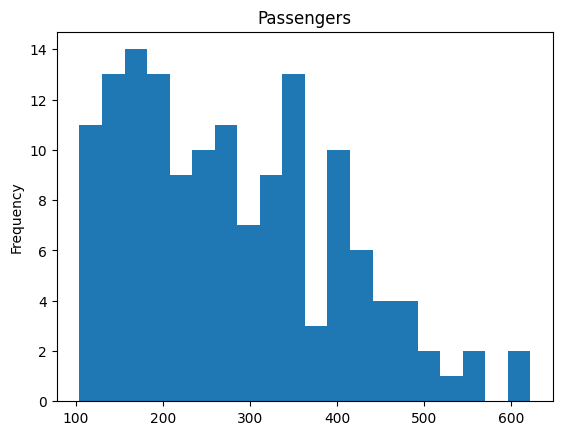

In [ ]:
df['Passengers'].plot(kind='hist', bins=20, title='Passengers')

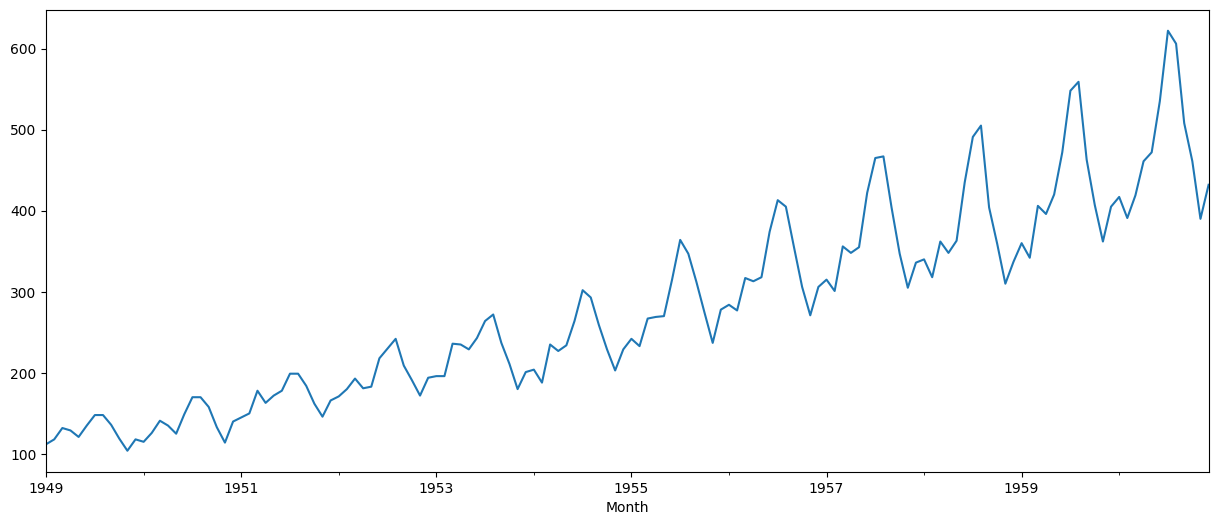

In [ ]:
df['Passengers'].plot(figsize = (15, 6));

In [ ]:
def first_order_differencing(data):
  differenced_data = data - data.shift(1)
  return differenced_data

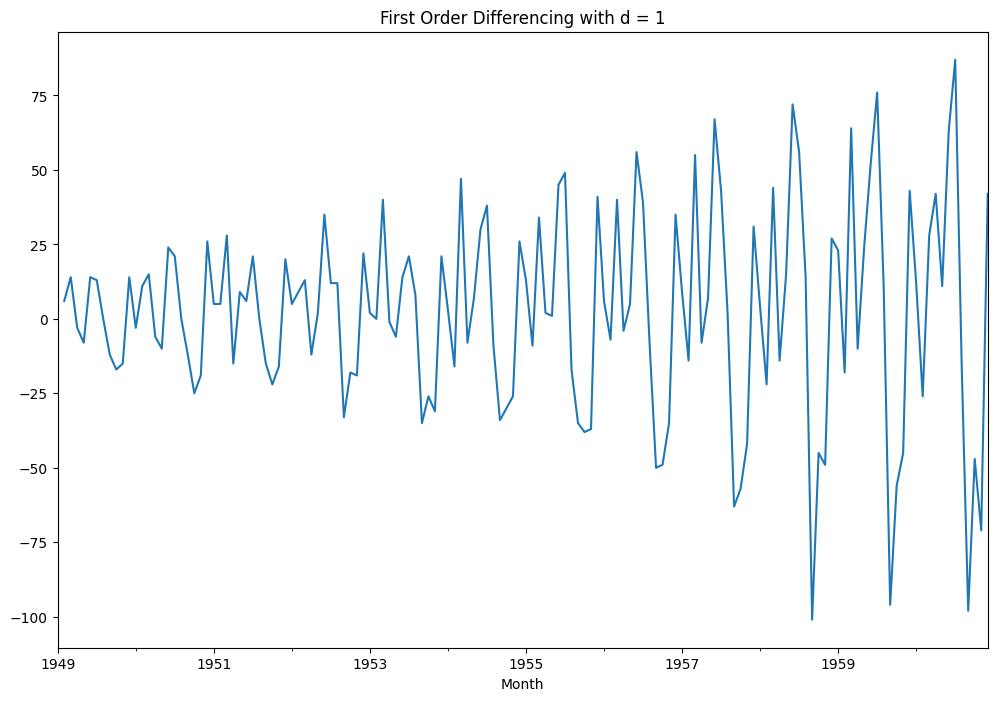

In [ ]:
df["First_Order_Differenced_Passengers"].plot(figsize = (12, 8), title = "First Order Differencing with d = 1")
plt.show()

In [ ]:
#Ho : Series is stationary v/s H1 : Series is non-stationary
from statsmodels.tsa.stattools import kpss
def kpss_test(series):

  kpss_stat, p_value, lags, critical_values = kpss(series)
  print('KPSS Statistic:', kpss_stat)
  print('p-value:', p_value)
  print('Critical Values:', critical_values)
  if p_value <= 0.05:
    print("Strong evidence against the null hypothesis, reject the null hypothesis. Series is non-stationary")
  else:
    print("Weak evidence against null hypothesis, fail to reject the null hypothesis. Series is stationary")

In [ ]:
df["First_Order_Differenced_Passengers"] = first_order_differencing(df["Passengers"])
kpss_test(df["First_Order_Differenced_Passengers"].dropna())

KPSS Statistic: 0.023897614400183967
p-value: 0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Weak evidence against null hypothesis, fail to reject the null hypothesis. Series is stationary


<ipython-input-283-58ccf062a75d>:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, p_value, lags, critical_values = kpss(series)


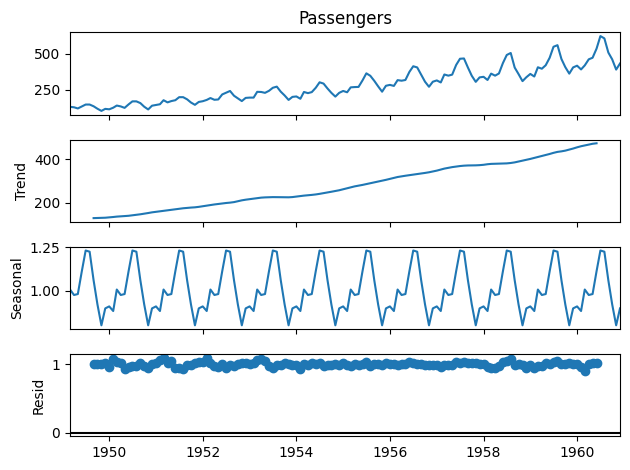

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
components = seasonal_decompose(df['Passengers'], model='multiplicative')
components.plot()
plt.show()

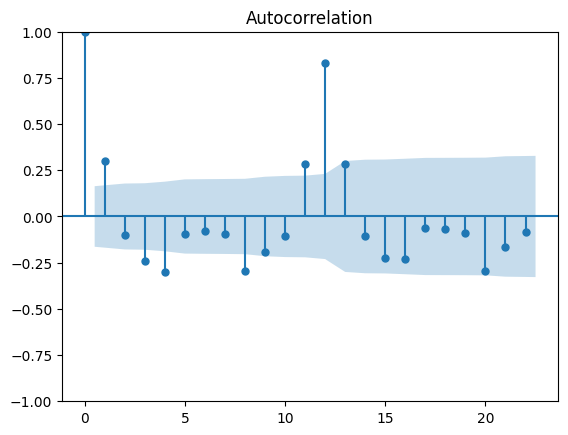

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df["First_Order_Differenced_Passengers"])
plt.show()

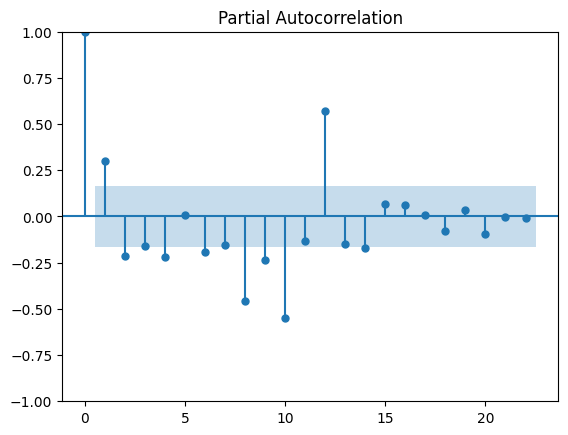

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df["First_Order_Differenced_Passengers"])
plt.show()

p = 1
q = 1
d = 1

In [ ]:
train_size = 108  # Use 75% of data for training
cv_size = 24
train = df.iloc[:train_size]
cv_set = df.iloc[train_size:train_size+cv_size]
test = df.iloc[train_size+cv_size:]
print(len(test))
print(len(cv_set))

12
24


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
model = ARIMA(train["Passengers"], order = (1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  108
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -490.640
Date:                Sun, 07 Apr 2024   AIC                            987.280
Time:                        09:02:50   BIC                            995.299
Sample:                    01-01-1949   HQIC                           990.531
                         - 12-01-1957                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4856      0.136     -3.567      0.000      -0.752      -0.219
ma.L1          0.8760      0.078     11.289      0.000       0.724       1.028
sigma2       559.5788     94.858      5.899      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


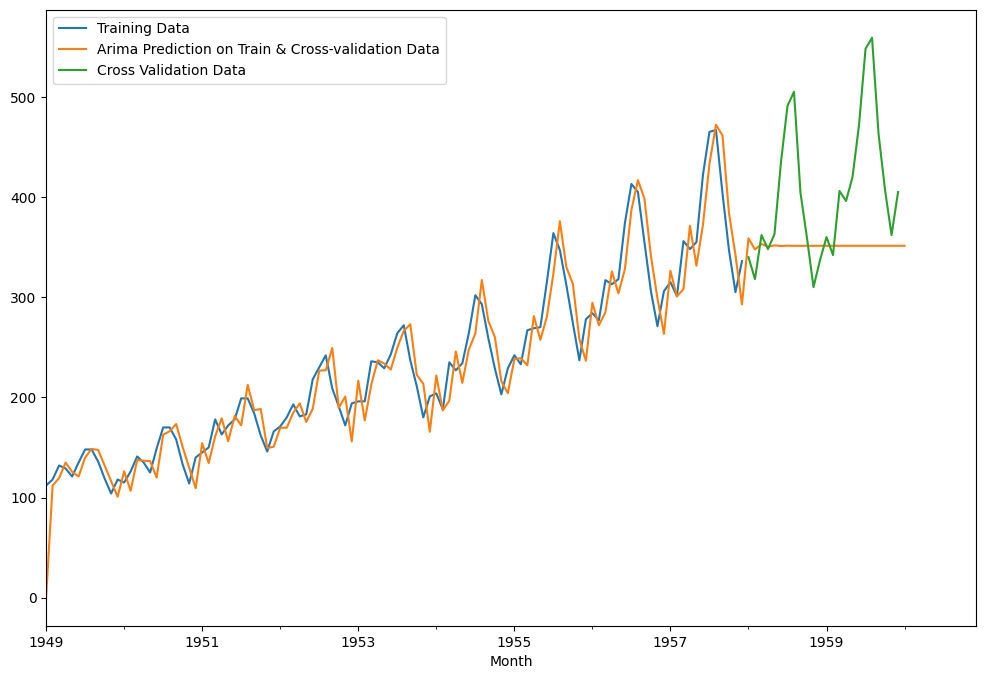

In [ ]:
df['Arima Prediction on Train & Cross-validation Data']=model_fit.predict(end = train_size + cv_size)
df['Training Data'] = train['Passengers']
df['Cross Validation Data'] = cv_set["Passengers"]
df['Training Data'].plot(figsize = (12, 8))
df['Arima Prediction on Train & Cross-validation Data'].plot(figsize=(12,8))
df['Cross Validation Data'].plot(figsize = (12,8))
plt.legend(loc='upper left')
plt.show()

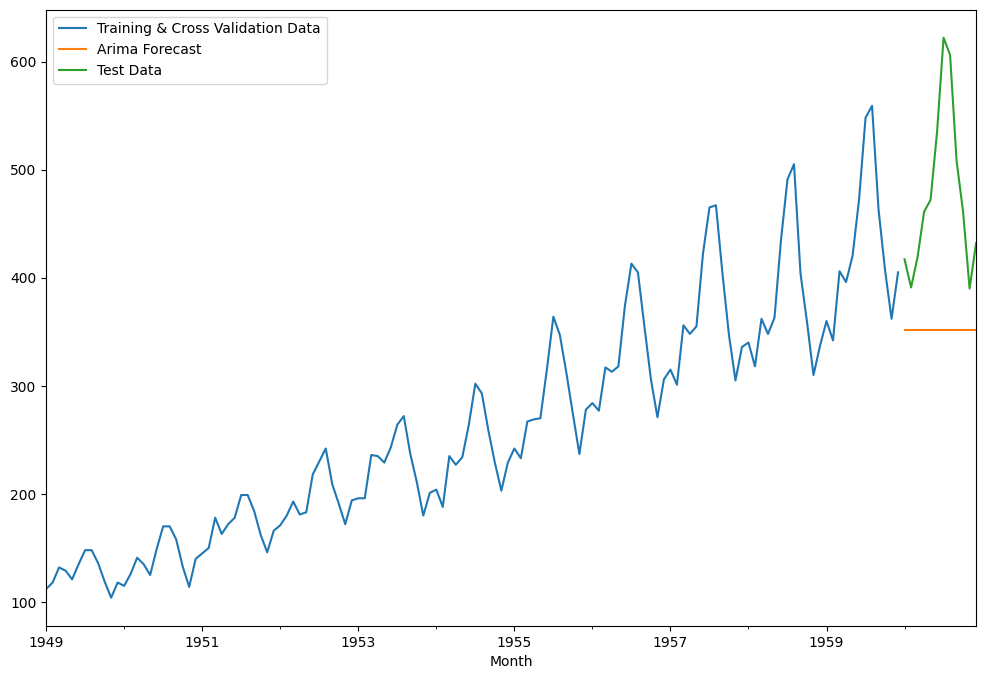

In [ ]:
df['Arima Forecast']=model_fit.predict(start = (train_size + cv_size), end = len(df))
df['Training & Cross Validation Data'] = df["Passengers"].iloc[:train_size + cv_size]
df['Test Data'] = test['Passengers']
df['Training & Cross Validation Data'].plot(figsize = (12,8))
df['Arima Forecast'].plot(figsize=(12,8))
df['Test Data'].plot(figsize = (12, 8))
plt.legend(loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
rmse_arima = mean_squared_error(test["Passengers"], df['Arima Forecast'].dropna(), squared=False)
print("RMSE:", rmse_arima)

RMSE: 145.3686030396001


In [ ]:
from sklearn.metrics import r2_score
r2_arima = r2_score(test["Passengers"], df['Arima Forecast'].dropna())
print("R-squared:", r2_arima)

R-squared: -2.8148094081799497


In [ ]:
model_2 = SARIMAX(train["Passengers"], order = (1,1,1), seasonal_order = (0,1,0,12))
model_2_fit = model_2.fit()
print(model_2_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                          Passengers   No. Observations:                  108
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 12)   Log Likelihood                -349.541
Date:                             Sun, 07 Apr 2024   AIC                            705.081
Time:                                     10:22:07   BIC                            712.743
Sample:                                 01-01-1949   HQIC                           708.177
                                      - 12-01-1957                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6085      0.312     -1.953      0.051      -1.219       0.002
ma.L1          0.3968      

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


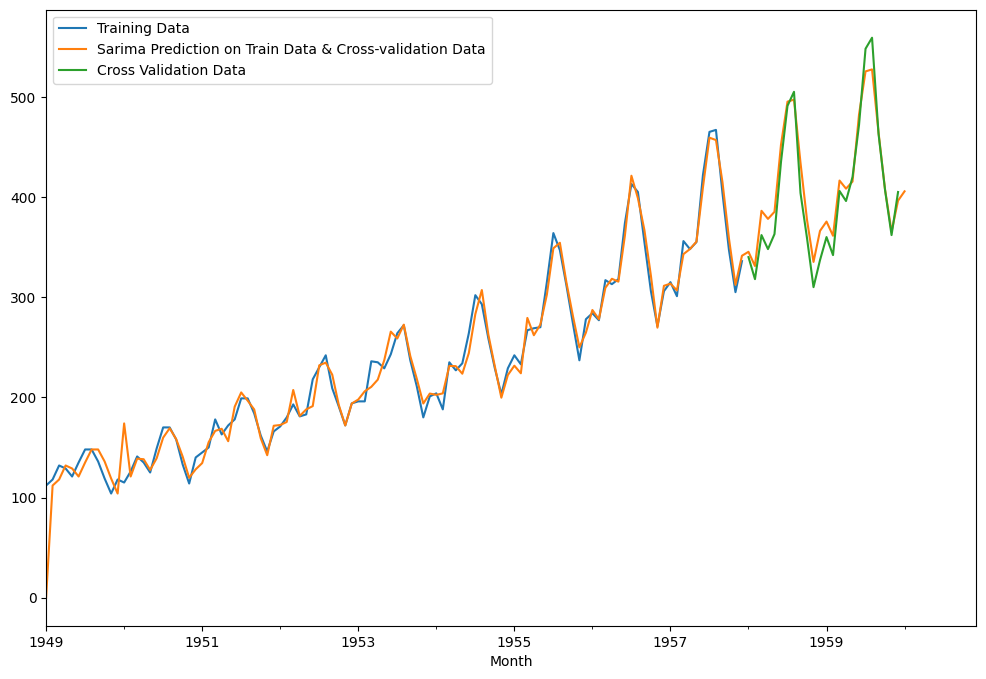

In [ ]:
df['Sarima Prediction on Train Data & Cross-validation Data']=model_2_fit.predict(end = train_size + cv_size)
df['Training Data'].plot(figsize = (12,8))
df['Sarima Prediction on Train Data & Cross-validation Data'].plot(figsize=(12,8))
df['Cross Validation Data'].plot(figsize = (12,8))
plt.legend(loc='upper left')
plt.show()

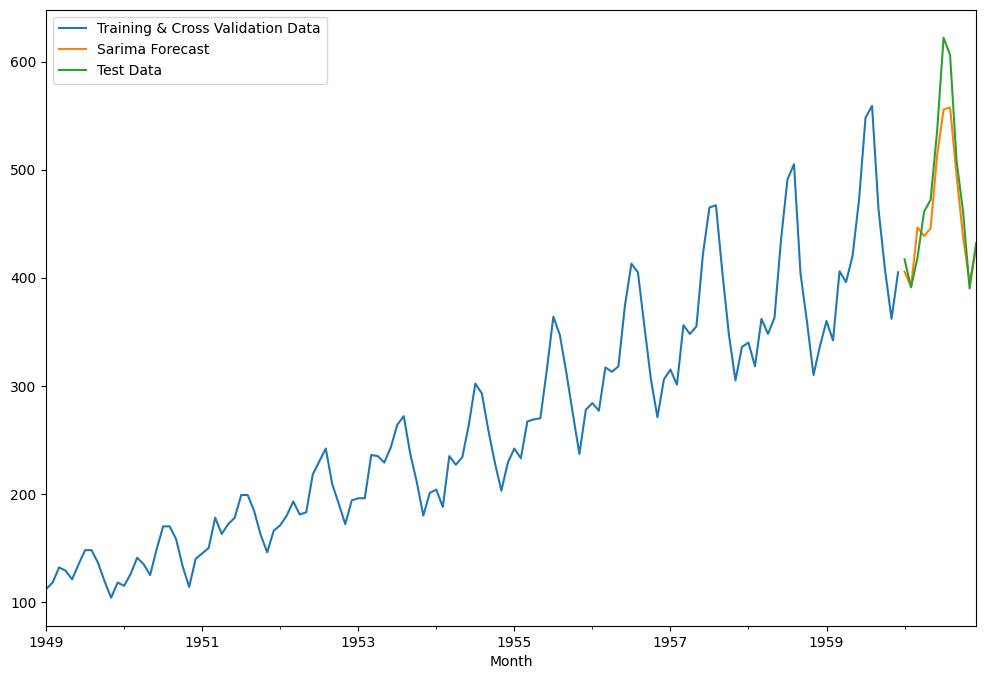

In [ ]:
df['Sarima Forecast']=model_2_fit.predict(start = (train_size + cv_size), end = len(df))
df['Training & Cross Validation Data'].plot(figsize = (12,8))
df['Sarima Forecast'].plot(figsize=(12,8))
df['Test Data'].plot(figsize = (12, 8))
plt.legend(loc='upper left')
plt.show()

In [ ]:
rmse_sarima = mean_squared_error(test["Passengers"], df['Sarima Forecast'].dropna(), squared=False)
print("RMSE:", rmse_sarima)

RMSE: 29.078120032497655


In [ ]:
r2_sarima = r2_score(test["Passengers"], df['Sarima Forecast'].dropna())
print("R-squared:", r2_sarima)

R-squared: 0.8473614397356533


In [ ]:
pip install pmdarima

auto_arima(y, X=None, start_p=2, d=None, start_q=2, max_p=5, max_d=2, max_q=5, start_P=1, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5, m=1, seasonal=True, stationary=False, information_criterion='aic', alpha=0.05, test='kpss', seasonal_test='ocsb', stepwise=True, n_jobs=1, start_params=None, trend=None, method='lbfgs', maxiter=50, offset_test_args=None, seasonal_test_args=None, suppress_warnings=True, error_action='trace', trace=False, random=False, random_state=None, n_fits=10, return_valid_fits=False, out_of_sample_size=0, scoring='mse', scoring_args=None, with_intercept='auto', sarimax_kwargs=None, **fit_args)

In [ ]:
from pmdarima.arima import auto_arima
auto_model_sarima = auto_arima(train["Passengers"], m=12, maxiter=50, return_valid_fits=True, start_p = 1, start_q = 1, d = 1)

In [ ]:
len(auto_model_sarima)

12

In [ ]:
mse_list = []
for i in range(len(auto_model_sarima)):
    model = auto_model_sarima[i]
    forecast = model.predict(n_periods=len(cv_set))
    mse = mean_squared_error(cv_set["Passengers"], forecast)
    mse_list.append(mse)

best_model_index = mse_list.index(min(mse_list))
best_model = auto_model_sarima[best_model_index]
best_mse = mse_list[best_model_index]
print("Best Model:", best_model)
print("MSE on Cross-Validation Data:", best_mse)

Best Model:  ARIMA(1,1,1)(1,1,1)[12]          
MSE on Cross-Validation Data: 317.2611652839997


In [ ]:
model_3 = SARIMAX(train["Passengers"], order = (1,1,1), seasonal_order = (1,1,1,12))
model_3_fit = model_3.fit()
print(model_3_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                         Passengers   No. Observations:                  108
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -348.579
Date:                            Sun, 07 Apr 2024   AIC                            707.158
Time:                                    10:23:55   BIC                            719.927
Sample:                                01-01-1949   HQIC                           712.318
                                     - 12-01-1957                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5901      0.337     -1.752      0.080      -1.250       0.070
ma.L1          0.3843      0.376   

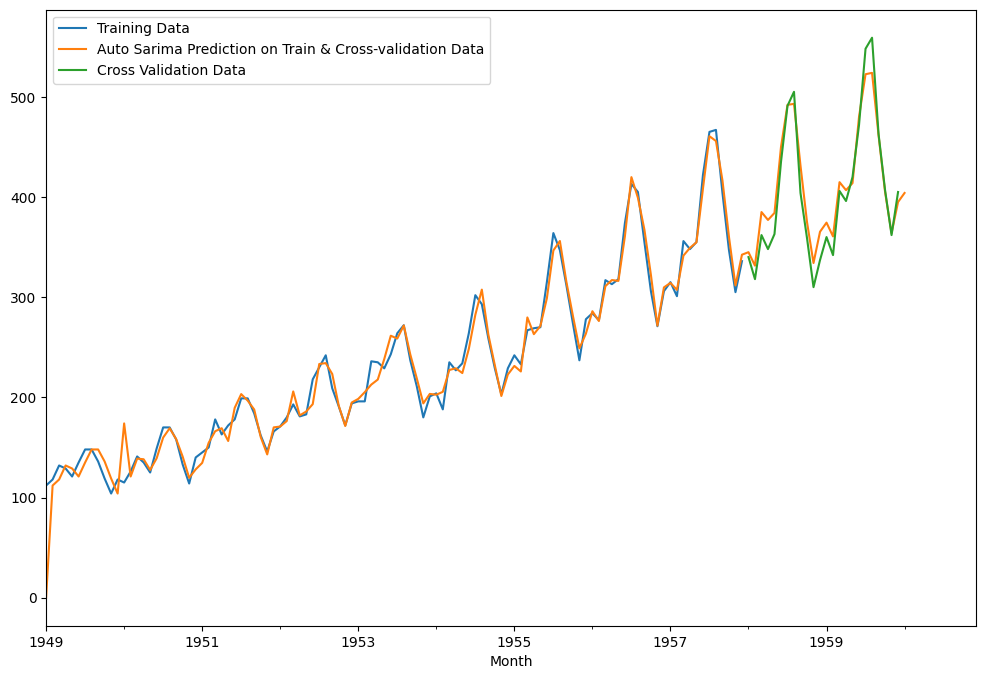

In [ ]:
df['Auto Sarima Prediction on Train & Cross-validation Data']=model_3_fit.predict(end = train_size + cv_size)
df['Training Data'].plot(figsize = (12, 8))
df['Auto Sarima Prediction on Train & Cross-validation Data'].plot(figsize=(12,8))
df['Cross Validation Data'].plot(figsize = (12, 8))
plt.legend(loc='upper left')
plt.show()

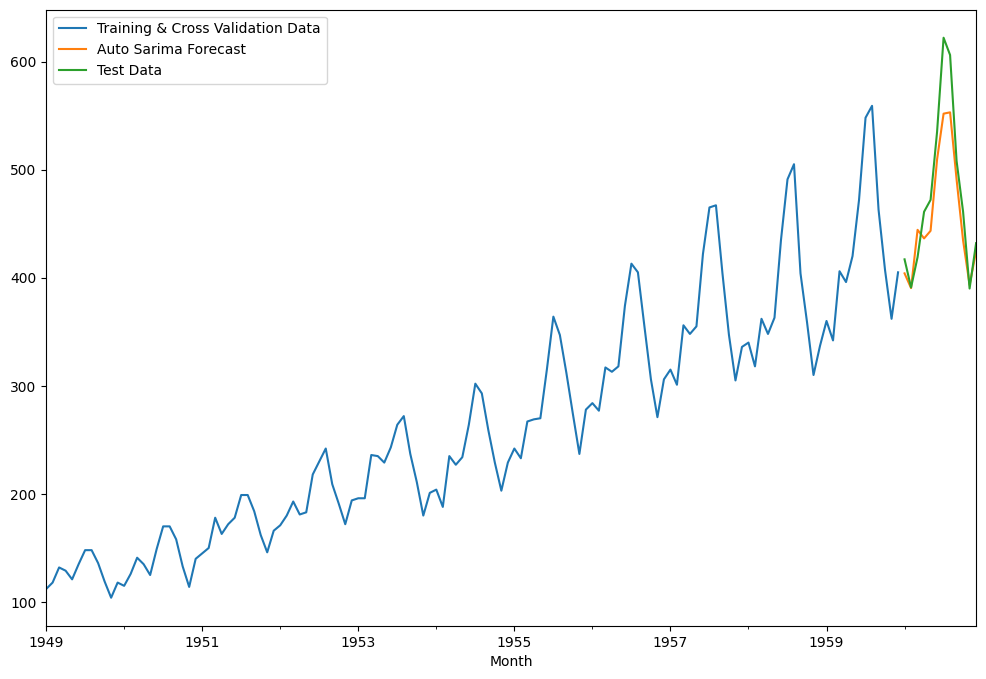

In [ ]:
df['Auto Sarima Forecast']=model_3_fit.predict(start = (train_size + cv_size), end = len(df))
df['Training & Cross Validation Data'].plot(figsize = (12, 8))
df['Auto Sarima Forecast'].plot(figsize=(12,8))
df['Test Data'].plot(figsize = (12, 8))
plt.legend(loc='upper left')
plt.show()

In [ ]:
rmse_auto_sarima = mean_squared_error(test["Passengers"], df['Auto Sarima Forecast'].dropna(), squared=False)
print("RMSE:", rmse_auto_sarima)

RMSE: 31.213867841291357


In [ ]:
r2_auto_sarima = r2_score(test["Passengers"], df['Auto Sarima Forecast'].dropna())
print("R-squared:", r2_auto_sarima)

R-squared: 0.8241158170799981
